## Why use Transfer learning?

- Can leverage an existing neural network architecture proven to work on problems similar to our own
- Can leverage a working network architecture which has already learned patterns on similar data to our own (often results in great results with less data)

## Contents
- Introduction to Transfer Learning with tensorflow
- Using a small dataset to experiment faster
- Building a transfer learning feature extraction model with tensorflow Hub
- Use tensorboard to track modelling experiments and results

# Part 1: Feature Extraction

Transfer Learning is leveraging a working model's existing architecture and learnd patterns for our own problem.

There are two main benefits:
1. Can leverage an existing neural network architecture proven to work on problems similar to our own
2. Can leverage a working network architecture which has already learned patterns on similar data to our own (often results in great results with less data)

In [1]:
# aRE WE USING A gpu?

In [2]:
!nvidia-smi

Sun Jul  7 17:37:51 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Downloading and becoming one with the data

In [3]:
# get data (10% of 10 food classes from Food 101)
import zipfile

# downlaod the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2024-07-07 17:37:51--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.207, 172.253.118.207, 74.125.200.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  19.9MB/s    in 11s     

2024-07-07 17:38:02 (15.3 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [4]:
# How many images in esach folder?
import os
# Walk through 10 percent data dir and list number of file
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent

## Creating data loaders (preparing the data)

We'll use the `ImageDataGenerator` class to load in nour images in batches

Now to import `ImageDataGenerator` we need to import it from `tensorflow.keras.preprocessing.image`.

Earlier it was `tensorflow.keras.preprocessing`.

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 5

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training Images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size = IMAGE_SHAPE,
                                                          batch_size = BATCH_SIZE,
                                                          class_mode = "categorical")
print("Test Images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size = IMAGE_SHAPE,
                                             batch_size = BATCH_SIZE,
                                             class_mode = "categorical")

Training Images:
Found 750 images belonging to 10 classes.
Test Images:
Found 2500 images belonging to 10 classes.


##Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:
* Tracking experiments with the TensorBoard callback
* Model checkpointing with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback

In [6]:
# Create TensorBoard callback (functionized becase we need to create a new one for each model)
import datetime
import tensorflow as tf
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to : {log_dir}")
  return tensorboard_callback


> 🔑**Note**: You can customise the directory where your tensorBoard logs (model training metrics) get saved to whgatever we like. The `log_dir` parameter we've created above is only one option.

## Creating models using TensorFlow Hub

In the past we've used TensorFlow to create our own models layer by layer froms cratch

Now we will do a similar process but the majority of our model's layer are going to come from TensorFlow Hub

We can access pre-trained models on: https://www.kaggle.com/models?tfhub-redirect=true

Browsing the TensorFlow Hub page and sorting for image classification, we found the following feature vector model link: https://www.kaggle.com/models/tensorflow/efficientnet/tensorFlow2/b0-feature-vector/1?tfhub-redirect=true

In [7]:
# Let's compare the following 2 models
resnet_url = "https://kaggle.com/models/google/resnet-v2/TensorFlow2/50-feature-vector/1"

efficientnet_url = "https://www.kaggle.com/models/tensorflow/efficientnet/tensorFlow2/b0-feature-vector/1?tfhub-redirect=true"

In [8]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [9]:
# Let's make a create_model function to create a model from the URL
def create_model(model_url, num_classes=10):
  """
  Takes a tensorFlow Hub URL and creates a Keras Sequential model with it

  Args:
   model_url (str) : A TensorFlow Hub feature extraction URL
   num_classes (int) : Number of output neurons in the output layer, should
   be equal to the number of target classes, default is 10.

  Returns:
   An uncompile Keras Sequential model with model_url as feature extractor layer
   and Dense output layer with nume_classes output neurons.
  """
  # Download the pretrained model and save it as a keras Layer
  feature_extraction_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the already learned patterns
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,))

  # Create our own model
  model = tf.keras.Sequential([
      feature_extraction_layer,
      layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model

### Creating ResNet tensorFlow Hub Feature Extraction model

In [10]:
train_data_10_percent.num_classes

10

In [11]:
# Create ResNet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [12]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [13]:
# Compile the model created
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [14]:
# Fit the model
resnet_history = resnet_model.fit(train_data_10_percent,
                 epochs=EPOCHS,
                 steps_per_epoch = len(train_data_10_percent),
                 validation_data = test_data,
                 validation_steps = len(test_data),
                 callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                        experiment_name = "resnet50V2")])

Saving TensorBoard log files to : tensorflow_hub/resnet50V2/20240707-180338
Epoch 1/5
24/24 [==============================] - 24s 638ms/step - loss: 1.7312 - accuracy: 0.4493 - val_loss: 1.1078 - val_accuracy: 0.6672
Epoch 2/5
24/24 [==============================] - 11s 460ms/step - loss: 0.8575 - accuracy: 0.7413 - val_loss: 0.8167 - val_accuracy: 0.7396
Epoch 3/5
24/24 [==============================] - 11s 466ms/step - loss: 0.6030 - accuracy: 0.8213 - val_loss: 0.7550 - val_accuracy: 0.7576
Epoch 4/5
24/24 [==============================] - 12s 508ms/step - loss: 0.4642 - accuracy: 0.8787 - val_loss: 0.7245 - val_accuracy: 0.7596
Epoch 5/5
24/24 [==============================] - 11s 451ms/step - loss: 0.3837 - accuracy: 0.9040 - val_loss: 0.6700 - val_accuracy: 0.7800


In [15]:
# Plot model performance
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

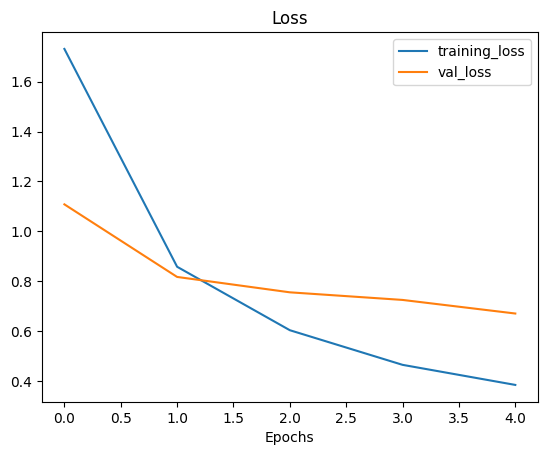

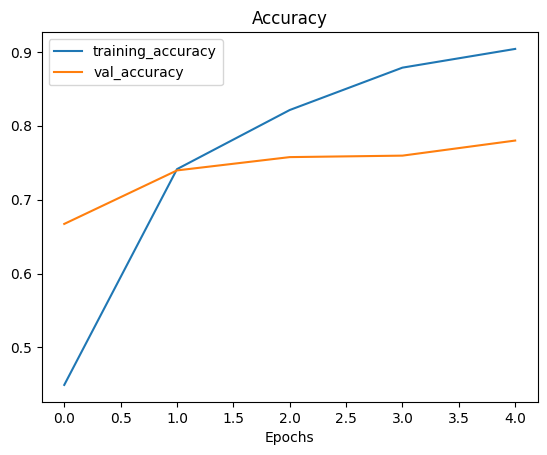

In [16]:
plot_loss_curves(resnet_history)

### Creating EfficientNetB0 tensorFlow Hub Feature Extraction model

In [17]:
train_data_10_percent.num_classes

10

In [18]:
# Create ResNet model
efficientnet_model = create_model(efficientnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [19]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


In [21]:
# Compile the model created
efficientnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [22]:
# Fit the model
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                 epochs=EPOCHS,
                 steps_per_epoch = len(train_data_10_percent),
                 validation_data = test_data,
                 validation_steps = len(test_data),
                 callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                        experiment_name = "efficientnetB0")])

Saving TensorBoard log files to : tensorflow_hub/efficientnetB0/20240707-181330
Epoch 1/5
24/24 [==============================] - 24s 569ms/step - loss: 1.8672 - accuracy: 0.4000 - val_loss: 1.3229 - val_accuracy: 0.7160
Epoch 2/5
24/24 [==============================] - 10s 413ms/step - loss: 1.0816 - accuracy: 0.7547 - val_loss: 0.8755 - val_accuracy: 0.8144
Epoch 3/5
24/24 [==============================] - 10s 437ms/step - loss: 0.7661 - accuracy: 0.8347 - val_loss: 0.7067 - val_accuracy: 0.8424
Epoch 4/5
24/24 [==============================] - 11s 451ms/step - loss: 0.6154 - accuracy: 0.8587 - val_loss: 0.6133 - val_accuracy: 0.8568
Epoch 5/5
24/24 [==============================] - 10s 427ms/step - loss: 0.5128 - accuracy: 0.8960 - val_loss: 0.5572 - val_accuracy: 0.8652


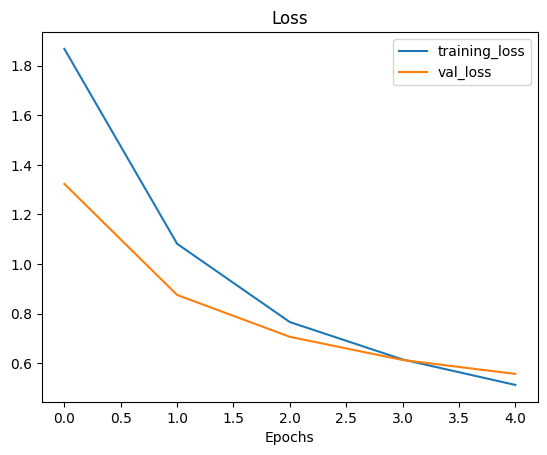

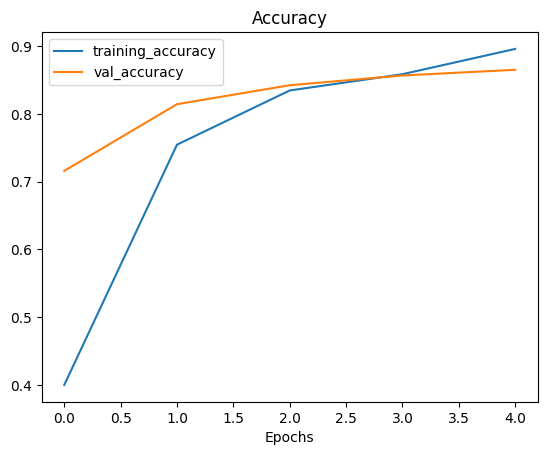

In [23]:
plot_loss_curves(efficientnet_history)

In [25]:
# number of layers in our efficientnetb0 feature extractor model?
len(efficientnet_model.layers[0].weights)

309

## Different types of Transfer Learning

* **"As is" transfer learning** - using an existing model with no changes what so ever (e.g using ImageNet model on 1000 ImageNet classes)
* **"Feature extraction" transfer learning** - use the prelearned patterns of an existing model (e.g EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problem(e.g 1000 classes -> 10 classes of food)
* **"Fine-tuning" transfer learning** - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers)

## Comparing our models results using TensorBoard

> 🔑**Note** When you upload things to tensorBoard.dev, you experiments are public. So if you are running private experiments do not upload

In [26]:
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing 2 different TF Hub feature extraction model architectures using 10% of the training data" \
  --one_shot

2024-07-07 18:28:00.153725: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-07 18:28:00.153780: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-07 18:28:00.155124: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-07 18:28:01.146983: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
****************************************************************
****************************************************************
****************************************************************

Uploading TensorBoard logs to https://tensorb

In [27]:
!tensorboard dev list

2024-07-07 18:29:54.277217: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-07 18:29:54.277269: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-07 18:29:54.278530: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-07 18:29:55.334011: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard.dev Uploader *****

This will list all experiments that you've uploaded to
https://tensorboard.dev. TensorBoard.dev experiments are visible
to everyone. Do not upload sensitive data.

Your use of this service is subject to